In [1]:
%config Completer.use_jedi = False

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score, f1_score
from tqdm import tqdm

In [3]:
# Define paths
base_path = "../input/strip-ai-background-clot"
positive_path = os.path.join(base_path, "positive")
negative_path = os.path.join(base_path, "negative")
metadata_path = os.path.join(base_path, "metadata.csv")

# Load metadata
metadata = pd.read_csv(metadata_path)
print("Metadata sample:")
display(metadata.head())


Metadata sample:


,image_id,slice_id,class,center_id,patient_id,image_num,label,file_size,group
0,01adc5_0,01adc5_0-imgslice.24.46,-1,11,01adc5,0,LAA,6.791663e+08,1
1,09644e_0,09644e_0-imgslice.32.2,-1,10,09644e,0,CE,3.793690e+08,1
2,0e4dac_0,0e4dac_0-imgslice.24.43,-1,11,0e4dac,0,CE,1.606370e+09,1
3,0d93ce_0,0d93ce_0-imgslice.22.7,-1,11,0d93ce,0,CE,1.190566e+09,1
4,055f6a_0,055f6a_0-imgslice.16.3,-1,6,055f6a,0,LAA,2.663309e+08,1



Displaying positive images:


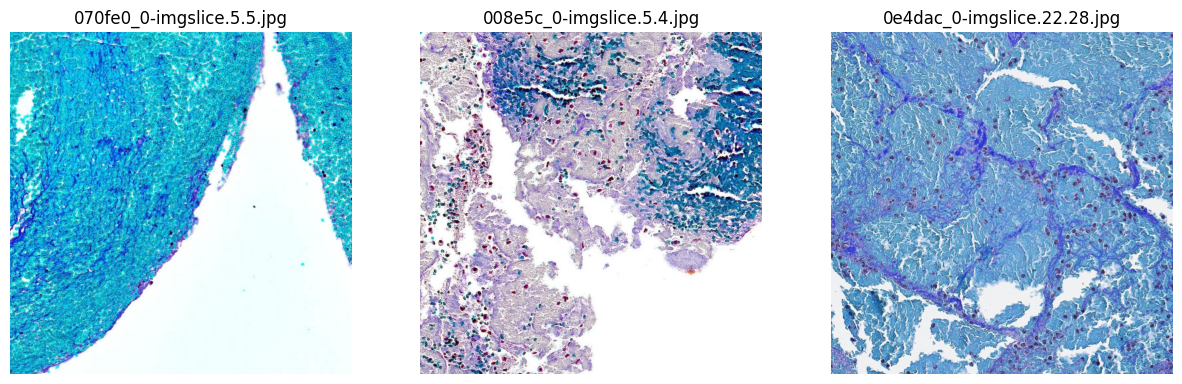


Displaying negative images:


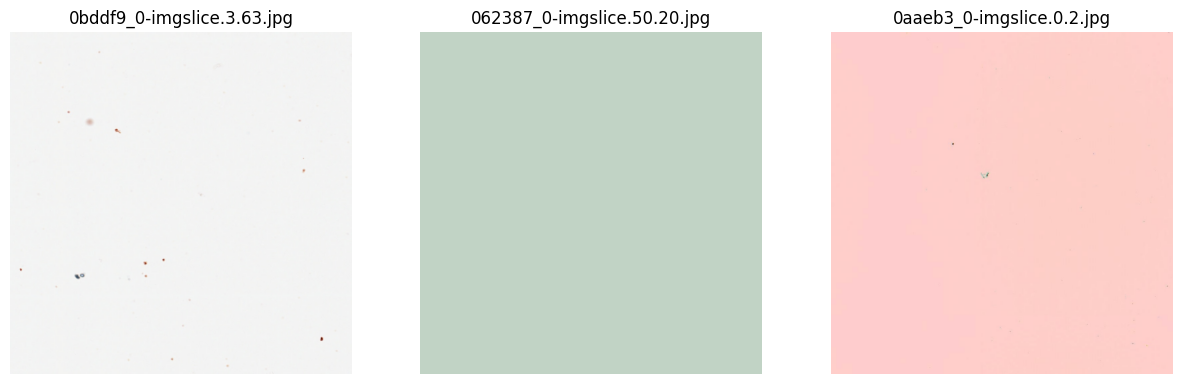


Positive and Negative counts from metadata:
class
-1    40092
 1     9999
 0     9999
Name: count, dtype: int64


In [4]:
# Helper function to load and display images
def display_images(folder_path, num_images=3):
    images = os.listdir(folder_path)[:num_images]
    plt.figure(figsize=(15, 10))
    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(image_name)
    plt.show()

# Display positive images
print("\nDisplaying positive images:")
display_images(positive_path)

# Display negative images
print("\nDisplaying negative images:")
display_images(negative_path)

# Processing metadata (e.g., displaying counts)
print("\nPositive and Negative counts from metadata:")
print(metadata["class"].value_counts())

In [5]:
class CellularImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [6]:
def prepare_data(base_path, positive_path, negative_path):
    # Get all image paths and labels
    positive_images = [os.path.join(positive_path, f) for f in os.listdir(positive_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    negative_images = [os.path.join(negative_path, f) for f in os.listdir(negative_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    image_paths = positive_images + negative_images
    labels = [1] * len(positive_images) + [0] * len(negative_images)
    
    # Split data into train and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    return train_paths, val_paths, train_labels, val_labels

In [27]:
class MetricTracker:
    def __init__(self):
        self.metrics = {
            'train_loss': [], 'train_acc': [], 
            'train_recall': [], 'train_f1': [],
            'val_acc': [],  'val_recall': [], 'val_f1': []
        }
    
    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key].append(value)
    
    def plot_metrics(self, save_path='/kaggle/working/training_metrics.png'):
        epochs = range(1, len(self.metrics['train_loss']) + 1)
        
        # Create a figure with 3x2 subplots
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        fig.suptitle('Training and Validation Metrics', fontsize=16)
        
        # Plot Loss
        axes[0, 0].plot(epochs, self.metrics['train_loss'], label='Training Loss')
        axes[0, 0].set_title('Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot Accuracy
        axes[0, 1].plot(epochs, self.metrics['train_acc'], label='Training')
        axes[0, 1].plot(epochs, self.metrics['val_acc'], label='Validation')
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        
        # Plot Recall
        axes[1, 1].plot(epochs, self.metrics['train_recall'], label='Training')
        axes[1, 1].plot(epochs, self.metrics['val_recall'], label='Validation')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        # Plot F1 Score
        axes[2, 0].plot(epochs, self.metrics['train_f1'], label='Training')
        axes[2, 0].plot(epochs, self.metrics['val_f1'], label='Validation')
        axes[2, 0].set_title('F1 Score')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('F1 Score')
        axes[2, 0].legend()
        axes[2, 0].grid(True)
        
        # Remove the empty subplot
        plt.show()
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

In [29]:
def create_model():
    # Load pre-trained MobileNetV3-Large
    model = models.mobilenet_v3_large(weights=True)
    
    # Modify the classifier for binary classification
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    
    return model

def calculate_metrics(all_predictions, all_labels):
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    return recall, f1


def train_model(model, train_loader, val_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)
    
    metric_tracker = MetricTracker()
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels_list = []
        
        # Add tqdm progress bar for the training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels_list.extend(labels.cpu().numpy())
                
                # Update progress bar description
                pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=100. * correct / total)
        
        train_acc = 100. * correct / total
        
        # Calculate training metrics
        train_recall, train_f1 = calculate_metrics(all_predictions, all_labels_list)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_labels_list = []
        
        # Add tqdm progress bar for the validation loop
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", unit="batch") as pbar:
                for images, labels in pbar:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
                    val_predictions.extend(predicted.cpu().numpy())
                    val_labels_list.extend(labels.cpu().numpy())
                    
                    # Update progress bar description
                    pbar.set_postfix(accuracy=100. * val_correct / val_total)
        
        val_acc = 100. * val_correct / val_total
        
        # Calculate validation metrics
        val_recall, val_f1 = calculate_metrics(val_predictions, val_labels_list)
        
        # Update learning rate
        scheduler.step(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Training Metrics:')
        print(f'  Accuracy: {train_acc:.2f}%')
        print(f'  Recall: {train_recall:.4f}')
        print(f'  F1 Score: {train_f1:.4f}')
        print(f'Validation Metrics:')
        print(f'  Accuracy: {val_acc:.2f}%')
        print(f'  Recall: {val_recall:.4f}')
        print(f'  F1 Score: {val_f1:.4f}')
        
        # Update metric tracker
        metric_tracker.update({
            'train_loss': running_loss/len(train_loader),
            'train_acc': train_acc,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'val_acc': val_acc,
            'val_recall': val_recall,
            'val_f1': val_f1
        })
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            
        print('-' * 60)

    
    # Plot all metrics at the end of training
    metric_tracker.plot_metrics()


In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Prepare data
train_paths, val_paths, train_labels, val_labels = prepare_data(base_path, positive_path, negative_path)

# Create datasets
train_dataset = CellularImageDataset(train_paths, train_labels, transform=transform)
val_dataset = CellularImageDataset(val_paths, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [31]:
# Create and move model to device
model = create_model()
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Epoch 1/10 Validation: 100%|██████████| 125/125 [00:24<00:00,  5.03batch/s, accuracy=99.7]


Epoch 1/10:
Training Loss: 0.0288
Training Metrics:
  Accuracy: 99.30%
  Recall: 0.9910
  F1 Score: 0.9930
Validation Metrics:
  Accuracy: 99.72%
  Recall: 0.9980
  F1 Score: 0.9973
------------------------------------------------------------


Epoch 2/10 Validation: 100%|██████████| 125/125 [00:23<00:00,  5.29batch/s, accuracy=99.7]


Epoch 2/10:
Training Loss: 0.0182
Training Metrics:
  Accuracy: 99.67%
  Recall: 0.9957
  F1 Score: 0.9967
Validation Metrics:
  Accuracy: 99.72%
  Recall: 0.9965
  F1 Score: 0.9972
------------------------------------------------------------


Epoch 3/10 Validation: 100%|██████████| 125/125 [00:23<00:00,  5.32batch/s, accuracy=99.8]


Epoch 3/10:
Training Loss: 0.0163
Training Metrics:
  Accuracy: 99.60%
  Recall: 0.9947
  F1 Score: 0.9960
Validation Metrics:
  Accuracy: 99.78%
  Recall: 0.9970
  F1 Score: 0.9977
------------------------------------------------------------


Epoch 4/10 Validation: 100%|██████████| 125/125 [00:24<00:00,  5.08batch/s, accuracy=99.7]


Epoch 4/10:
Training Loss: 0.0140
Training Metrics:
  Accuracy: 99.71%
  Recall: 0.9962
  F1 Score: 0.9971
Validation Metrics:
  Accuracy: 99.72%
  Recall: 0.9965
  F1 Score: 0.9972
------------------------------------------------------------


Epoch 5/10 Validation: 100%|██████████| 125/125 [00:24<00:00,  5.08batch/s, accuracy=99.8]


Epoch 5/10:
Training Loss: 0.0182
Training Metrics:
  Accuracy: 99.68%
  Recall: 0.9956
  F1 Score: 0.9968
Validation Metrics:
  Accuracy: 99.85%
  Recall: 0.9980
  F1 Score: 0.9985
------------------------------------------------------------


Epoch 6/10 Validation: 100%|██████████| 125/125 [00:24<00:00,  5.18batch/s, accuracy=99.8]


Epoch 6/10:
Training Loss: 0.0156
Training Metrics:
  Accuracy: 99.73%
  Recall: 0.9964
  F1 Score: 0.9973
Validation Metrics:
  Accuracy: 99.75%
  Recall: 0.9955
  F1 Score: 0.9975
------------------------------------------------------------


Epoch 7/10 Validation: 100%|██████████| 125/125 [00:24<00:00,  5.19batch/s, accuracy=99.3]


Epoch 7/10:
Training Loss: 0.0166
Training Metrics:
  Accuracy: 99.62%
  Recall: 0.9954
  F1 Score: 0.9962
Validation Metrics:
  Accuracy: 99.30%
  Recall: 0.9970
  F1 Score: 0.9930
------------------------------------------------------------


Epoch 8/10 Validation: 100%|██████████| 125/125 [00:23<00:00,  5.29batch/s, accuracy=99.7]


Epoch 8/10:
Training Loss: 0.0168
Training Metrics:
  Accuracy: 99.65%
  Recall: 0.9954
  F1 Score: 0.9965
Validation Metrics:
  Accuracy: 99.72%
  Recall: 0.9955
  F1 Score: 0.9972
------------------------------------------------------------


Epoch 9/10 Validation: 100%|██████████| 125/125 [00:24<00:00,  5.20batch/s, accuracy=99.7]


Epoch 9/10:
Training Loss: 0.0107
Training Metrics:
  Accuracy: 99.79%
  Recall: 0.9972
  F1 Score: 0.9979
Validation Metrics:
  Accuracy: 99.67%
  Recall: 0.9960
  F1 Score: 0.9967
------------------------------------------------------------


Epoch 10/10 Validation: 100%|██████████| 125/125 [00:23<00:00,  5.26batch/s, accuracy=99.7]


Epoch 10/10:
Training Loss: 0.0104
Training Metrics:
  Accuracy: 99.77%
  Recall: 0.9970
  F1 Score: 0.9977
Validation Metrics:
  Accuracy: 99.72%
  Recall: 0.9965
  F1 Score: 0.9972
------------------------------------------------------------


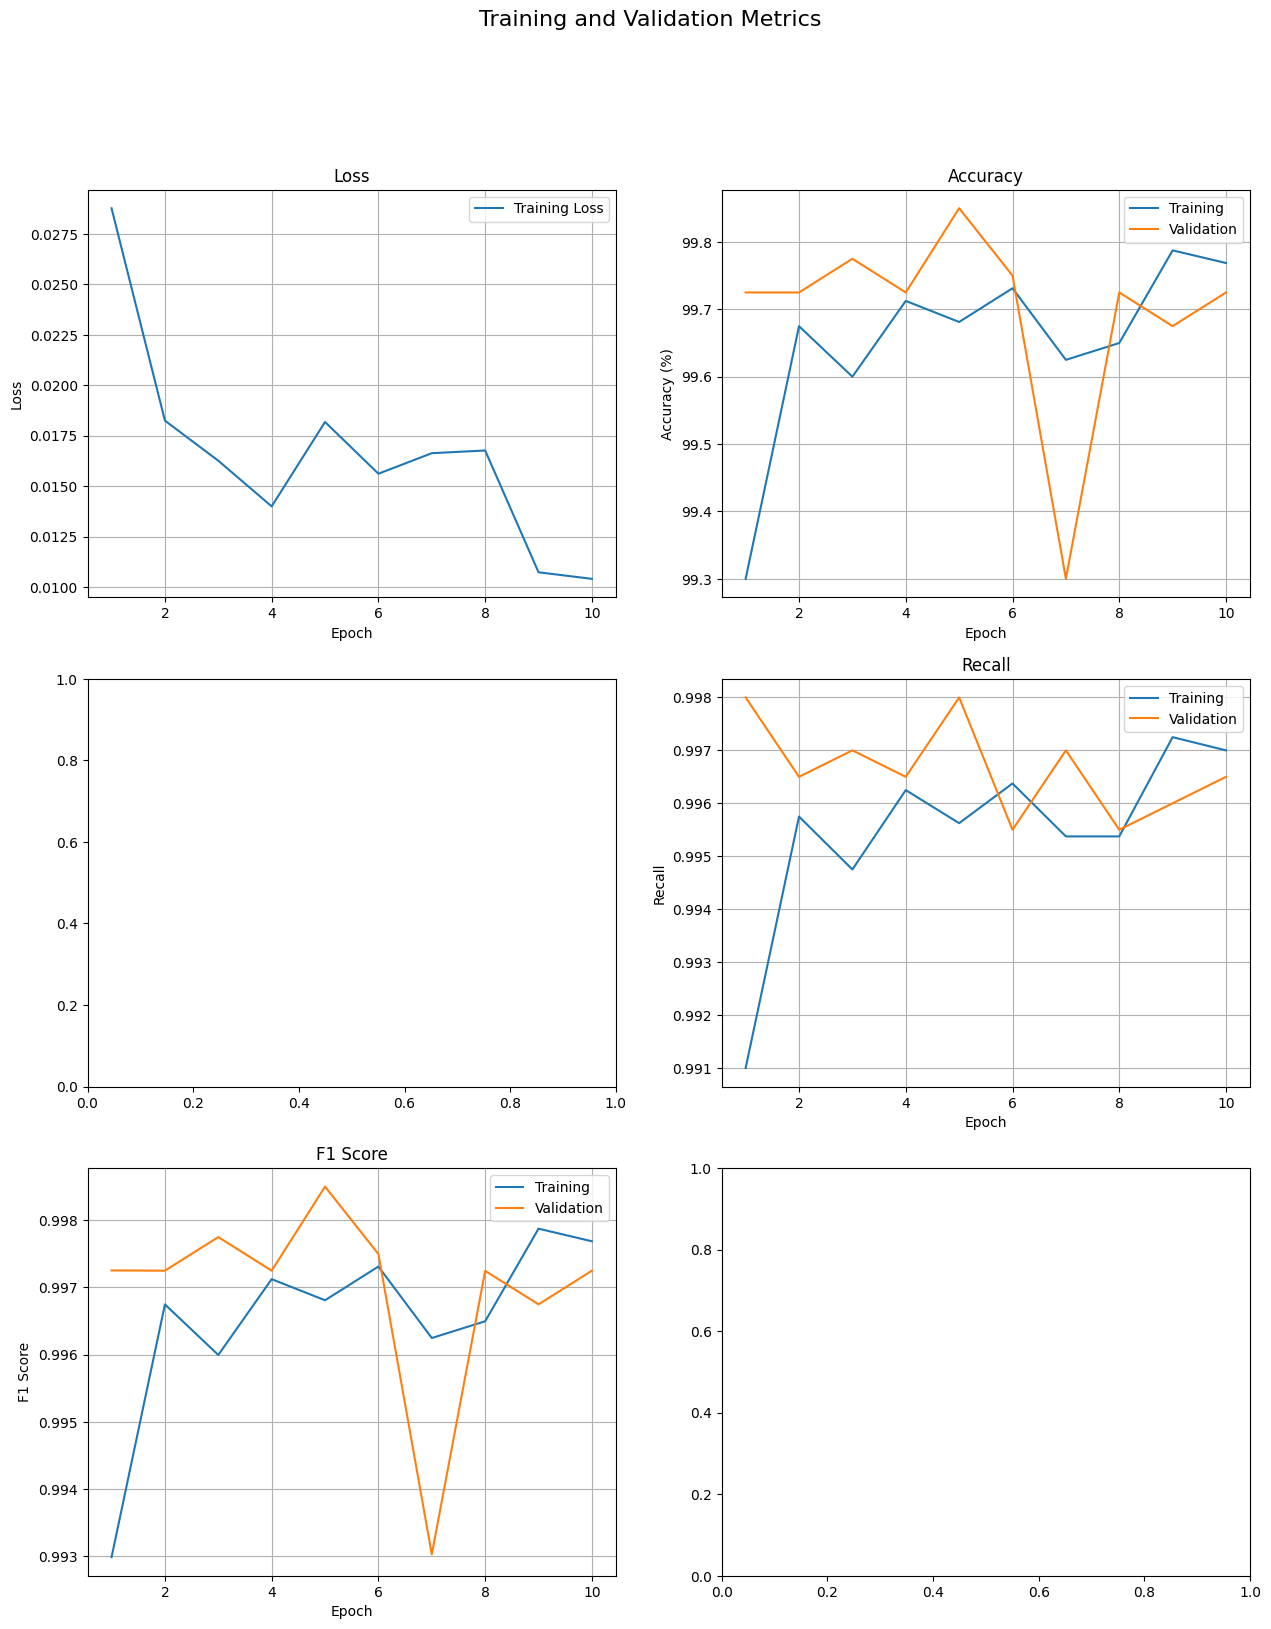

In [32]:
# Train the model
train_model(model, train_loader, val_loader, device)